In [1]:
from IPython.core.display import HTML
with open('../style.css') as file:
    css = file.read()
HTML(css)

# Huffman's Algorithm for Lossless Data Compression

In [2]:
import graphviz as gv

This notebook presents <em style="color:blue;">coding trees</em>.  Given an alphabet $\Sigma$ of characters, 
we define the set $\mathcal{K}$ of coding trees by induction:

  - $\texttt{Leaf}(c,f) \in \mathcal{K} $ if $c \in \Sigma$ and $f \in \mathbb{N}$

    An expression of the form $\texttt{Leaf}(c,f)$ represent a *leaf* in a coding tree.  
    * $c$ is a letter from the alphabet $\Sigma$ and 
    * $f$ is the *frequency* of the letter $c$ in the string $s$ that is to be encoded.

  - $\texttt{Node}(l,r) \in \mathcal{K}$ if $l \in\mathcal{K}$ and $r \in \mathcal{K}$

    The expressions $\texttt{Node}(l,r)$ represent the *inner nodes* of the coding-tree.

The class `CodingTree` is a *superclass* for constructing coding trees.  It has one static variable `sNodeCount`.  This variable is used to equip all nodes with a unique identifier.  This identifier is used to draw the trees using [graphviz](https://graphviz.org/).

Every object of class `CodingTree` has a uniques identifier `mID` that is stored as a member variable.  This identifier is only used by `graphviz`.

In [4]:
class CodingTree:
    sNodeCount = 0
    
    def __init__(self):
        CodingTree.sNodeCount += 1
        self.mID = CodingTree.sNodeCount
        
    def count(self):
        "compute the number of characters"
        pass
        
    def cost(self):
        "compute the number of bits used by this coding tree"
        pass
        
    def getID(self):
        return self.mID  # used only by graphviz

The function `make_string` is a helper function that is used to simplify the implementation of `__str__`.
  - `self` is the object that is to be rendered as a string
  - `attributes` is a list of those member variables that are used to produce the string

In [5]:
def _make_string(self, Attributes):
        # map the function __str__ to all attributes and join them with a comma
        name = self.__class__.__name__
        return f"{name}({', '.join(map(str, [getattr(self, at) for at in Attributes]))})"
    
CodingTree._make_string = _make_string

The method $t.\texttt{toDot}()$ takes a binary trie $t$ and returns a graph that depicts the tree $t$.

In [6]:
def toDot(self):
    dot = gv.Digraph(node_attr={'shape': 'record', 'style': 'rounded'})
    nodeDict = {}
    self._collectIDs(nodeDict)
    for n, t in nodeDict.items():
        if isinstance(t, Leaf):
            if t.mCharacter == ' ':
                dot.node(str(n), label='{ \' \' |' + "{:,}".format(t.mFrequency) + '}') 
            elif t.mCharacter == '\t':
                dot.node(str(n), label='{ \'\\\\t\' |' + "{:,}".format(t.mFrequency) + '}') 
            elif t.mCharacter == '\n':
                dot.node(str(n), label='{ \'\\\\n\' |' + "{:,}".format(t.mFrequency) + '}')     
            elif t.mCharacter == '\v':
                dot.node(str(n), label='{ \'\\\\v\' |' + "{:,}".format(t.mFrequency) + '}')     
            else:
                dot.node(str(n), label='{' + str(t.mCharacter) + '|' + "{:,}".format(t.mFrequency) + '}') 
        elif isinstance(t, Node):
            dot.node(str(n), label="{:,}".format(t.count()))
        else:
            assert False, f'Unknown node {t}'
    for n, t in nodeDict.items():
        if isinstance(t, Node):
            dot.edge(str(n), str(t.mLeft .getID()), label='0')
            dot.edge(str(n), str(t.mRight.getID()), label='1')
    return dot

CodingTree.toDot = toDot

The method $t.\texttt{collectIDs}(d)$ takes a coding tree $t$ and a dictionary $d$ and updates the dictionary so that the following holds:
$$ d[\texttt{id}] = n \quad \mbox{for every node $n$ in $t$.} $$
Here, $\texttt{id}$ is the unique identifier of the node $n$, i.e. $d$ associates the identifiers with the corresponding nodes.

In [7]:
def _collectIDs(self, nodeDict):
    nodeDict[self.getID()] = self
    if isinstance(self, Node):
        self.mLeft ._collectIDs(nodeDict)
        self.mRight._collectIDs(nodeDict)
        
CodingTree._collectIDs = _collectIDs

The class `Leaf` represents a leaf of the form $\texttt{Leaf}(c, f)$.  It maintains two member variables.
  - $c$ represents the character that is encoded.  This character is stored in the member variable `mCharacter`.
  - $f$ represents the number of occurrences of the character $c$ in the string $s$ that is to be encoded and is stored in the member variable `mFrequency`.
  
The class `Leaf` implements the method `__lt__`. This way, nodes in a coding tree can be ordered.  The ordering between nodes is given as follows:
* $\texttt{Leaf}(c, f) < \texttt{Node}(l, r)$, 

  i.e. leaf nodes are smaller than inner nodes.
* $\texttt{Leaf}(c_1, f_1) < \texttt{Leaf}(c_2, f_2) \Leftrightarrow c_1 < c_2$, 

  i.e. leaf nodes are compared by comparing their characters lexicographically.

In [8]:
class Leaf(CodingTree):
    def __init__(self, c, f):
        CodingTree.__init__(self)
        self.mCharacter = c
        self.mFrequency = f
        
    def count(self):
        return self.mFrequency
    
    def cost(self):
        return 0
    
    def __str__(self):
        return _make_string(self, ['mCharacter', 'mFrequency'])
    
    def __lt__(self, other):
        if isinstance(other, Node):
            return True
        return self.mCharacter < other.mCharacter

The class `Node` represents an inner node of the form $\texttt{Node}(l, r)$.  It maintains two member variables:
  - `self.mLeft` is the left subtree $l$,
  - `self.mRight` is the right subtree $r$.
  
The class `Node` implements the method `__lt__`. This way, nodes in a coding tree can be ordered.  The ordering between nodes is given as follows:
* $\texttt{Leaf}(c, f) < \texttt{Node}(l, r)$, 

  i.e. leaf nodes are smaller than inner nodes.
* $\texttt{Node}(l_1, r_1) < \texttt{Node}(l_2, r_2) \Leftrightarrow l_1 < l_2$, 

  i.e. inner nodes are compared by comparing their left subtrees.  

In [9]:
class Node(CodingTree):
    def __init__(self, l, r):
        CodingTree.__init__(self)
        self.mLeft  = l
        self.mRight = r

    def count(self):
        return self.mLeft.count() + self.mRight.count()
        
    def cost(self):
        return self.mLeft.cost() + self.mRight.cost() + self.count()
    
    def __str__(self):
        return _make_string(self, ['mLeft', 'mRight'])
    
    def __lt__(self, other):
        if isinstance(other, Leaf):
            return False
        return self.mLeft < other.mLeft

## Building a Coding Tree

The module `heapq` provides priority queues.  The api is given at https://docs.python.org/3/library/heapq.html.
We will use two methods:
* `heapq.heappush(H, p)`
  pushes the priority `p` onto the heap.  For this to be possible, `p` has to be an object of a class that provides the 
  method `__lt__`.  The expression `p.__lt__(q)` is `True` if `p` is smaller than `q`.
* `heapq.heappop(H)` 
  removes **and** returns the element from the heap `H` that has the highest priority, i.e. the smallest element.

The implementation of this module represents heaps as arrays.  Therefore, 
* to test whether a heap `H` is empty we can write `H == []` since `[]` is the empty heap.
* to create an empty heap we write `H = []`,
* to get the element with the highest priority in the heap `H` we write `H[0]`,
* to get the number of elements in `H` we can write `len(H)`.

In [10]:
import heapq

In [11]:
H = []
heapq.heappush(H, 7)
heapq.heappush(H, 1)
heapq.heappush(H, 0)
heapq.heappush(H, 6)
H

[0, 6, 1, 7]

In [12]:
a = heapq.heappop(H)
print('a = ', a)
H

a =  0


[1, 6, 7]

The function `coding_tree` implements [Huffman's algorithm](https://en.wikipedia.org/wiki/Huffman_coding) for data compression. 
The input $M$ is a set of pairs of the form
$$ \bigl\{ (c_1, f_1), \cdots, (c_k, f_k)\bigr\} $$
where $c_i$ is a character and $f_i$ is the number of times this character occurs in the string $s$ that is to be encoded.  Huffman's algorithm is
<em style="color:blue;">greedy</em>:  It always combines those coding trees that have the *least* character count so far as this results in the smallest cost increase.

The heap `H` that is maintained by this function is a priority queue which is represented by an array that is structured as a heap.  The items in this priority queue are pairs of the form
$$ \bigl( t.\texttt{count}(), t \bigr)  $$
where $t$ is a coding tree and $t.\texttt{count}()$ is the count of this coding tree.

In [13]:
def coding_tree(M):
    H = []  # empty priority queue
    for c, f in M:
        heapq.heappush(H, (f, Leaf(c, f)))
    while len(H) > 1:
        ac, a = heapq.heappop(H)
        bc, b = heapq.heappop(H)
        heapq.heappush(H, (ac + bc, Node(a, b)))
    return H[0][1]

Let us test this with a trivial example.

In [14]:
import math

The function `log2(n)` computes $\log_2(n)$.

In [15]:
def log2(n):
    return math.log(n) / math.log(2)

In [16]:
log2(8)

3.0

The function `demo(M)`takes one argument `M` that is a set of pairs of the form
$$ M = \bigl\{ \langle c_1, f_1 \rangle, \cdots,  \langle c_n, f_n \rangle \bigr\} $$
Here, $c_1$, $\cdots$, $c_n$ are characters and $f_1, \cdots, f_n$ are the frequencies with which these 
characters occur in a given string that is to be encoded.

The function builds the Huffman tree that is optimal for these characters. Additionally the function prints the 
percentage of memory savings that can be achieved with a Huffman tree.  This number is also returned.

In [17]:
def demo(M):
    K = coding_tree(M)
    display(K.toDot())
    n = math.ceil(log2(len(M)))
    cost_huffman  = K.cost()
    cost_constant = n * K.count()
    savings       = (cost_constant - cost_huffman) / cost_constant
    print(f'cost of encoding with Huffman coding tree : {"{:,}".format(cost_huffman)} bits')
    print(f'cost of encoding with {n} bits              : {"{:,}".format(cost_constant)} bits')
    print(f'savings: {100 * savings}%')
    return savings

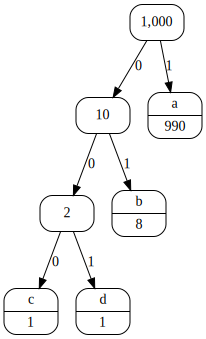

cost of encoding with Huffman coding tree : 1,012 bits
cost of encoding with 2 bits              : 2,000 bits
savings: 49.4%


0.494

In [18]:
demo({ ('a', 990), ('b', 8), ('c', 1), ('d', 1) })

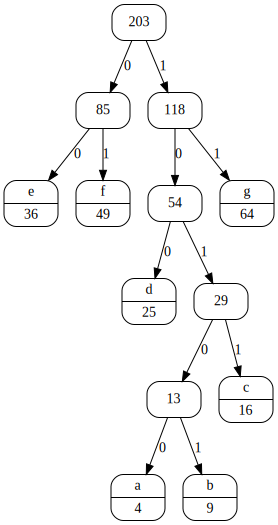

cost of encoding with Huffman coding tree : 502 bits
cost of encoding with 3 bits              : 609 bits
savings: 17.569786535303777%


0.17569786535303777

In [19]:
demo({ ('a', 4), ('b', 9), ('c', 16), ('d', 25), ('e', 36), ('f', 49), ('g', 64) })

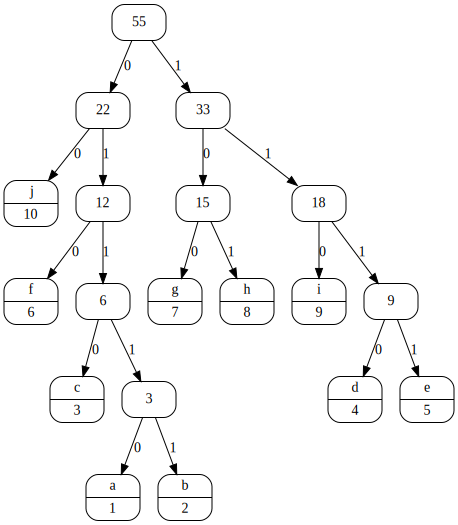

cost of encoding with Huffman coding tree : 173 bits
cost of encoding with 4 bits              : 220 bits
savings: 21.363636363636363%


0.21363636363636362

In [20]:
demo({ ('a', 1), ('b', 2), ('c', 3), ('d', 4), ('e', 5), ('f', 6), ('g', 7), ('h', 8), ('i', 9), ('j', 10) })

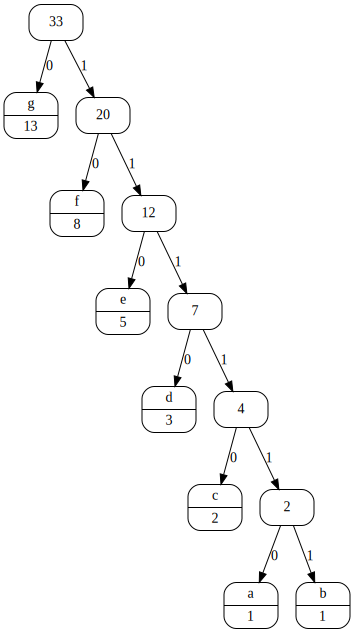

cost of encoding with Huffman coding tree : 78 bits
cost of encoding with 3 bits              : 99 bits
savings: 21.21212121212121%


0.21212121212121213

In [21]:
demo({ ('a', 1), ('b', 1), ('c', 2), ('d', 3), ('e', 5), ('f', 8), ('g', 13) })

The function `demo_file(fn)` reads the file with name `fn`  and calculates the frequency of all characters occurring in `fn`.  Using these frequencies it computes the Huffman coding tree.

In [22]:
def demo_file(fn):
    with open(fn, 'r') as file:
        s = file.read() # read file as string s
    Frequencies = {}
    for c in s:
        f = Frequencies.get(c, 0)
        f += 1
        Frequencies[c] = f
    M = { (c, f) for (c, f) in Frequencies.items() }
    print(M)
    return demo(M)

In [23]:
!cat alice.txt


                ALICE'S ADVENTURES IN WONDERLAND

                          Lewis Carroll

               THE MILLENNIUM FULCRUM EDITION 3.0




                            CHAPTER I

                      Down the Rabbit-Hole


  Alice was beginning to get very tired of sitting by her sister
on the bank, and of having nothing to do:  once or twice she had
peeped into the book her sister was reading, but it had no
pictures or conversations in it, `and what is the use of a book,'
thought Alice `without pictures or conversation?'

  So she was considering in her own mind (as well as she could,
for the hot day made her feel very sleepy and stupid), whether
the pleasure of making a daisy-chain would be worth the trouble
of getting up and picking the daisies, when suddenly a White
Rabbit with pink eyes ran close by her.

  There was nothing so VERY remarkable in that; nor did Alice
think it so VERY much out of the way to hear the Rabbit say to
itself, `Oh dear!  Oh dear!  I shall be late!'

{('?', 202), ('a', 8153), ('z', 77), ('l', 4618), ('E', 188), ('Q', 84), ('r', 5297), ('K', 82), ('C', 145), ('f', 1927), (']', 2), ('d', 4739), ('W', 237), ('t', 10217), ('v', 804), ('0', 1), ('H', 284), (')', 55), ('G', 83), ('[', 2), ('c', 2254), ('"', 113), ('(', 56), ('N', 120), ('o', 7970), ('3', 1), ('T', 472), ('P', 64), ('O', 176), ('S', 218), ('x', 144), ('Z', 1), ("'", 1763), ('V', 42), (';', 194), ('L', 98), ('.', 978), ('-', 669), (' ', 28918), ('`', 1109), ('D', 192), ('!', 450), ('I', 733), ('_', 4), ('*', 60), ('w', 2438), ('b', 1384), ('Y', 114), ('B', 91), ('X', 4), ('U', 66), ('k', 1076), ('p', 1460), ('q', 125), ('M', 200), ('F', 74), ('y', 2150), ('s', 6282), ('h', 7090), ('u', 3402), ('j', 138), ('J', 8), ('m', 1907), ('n', 6896), ('A', 638), (',', 2418), ('\n', 3604), ('e', 13386), ('g', 2448), ('R', 140), ('i', 6781), (':', 233)}


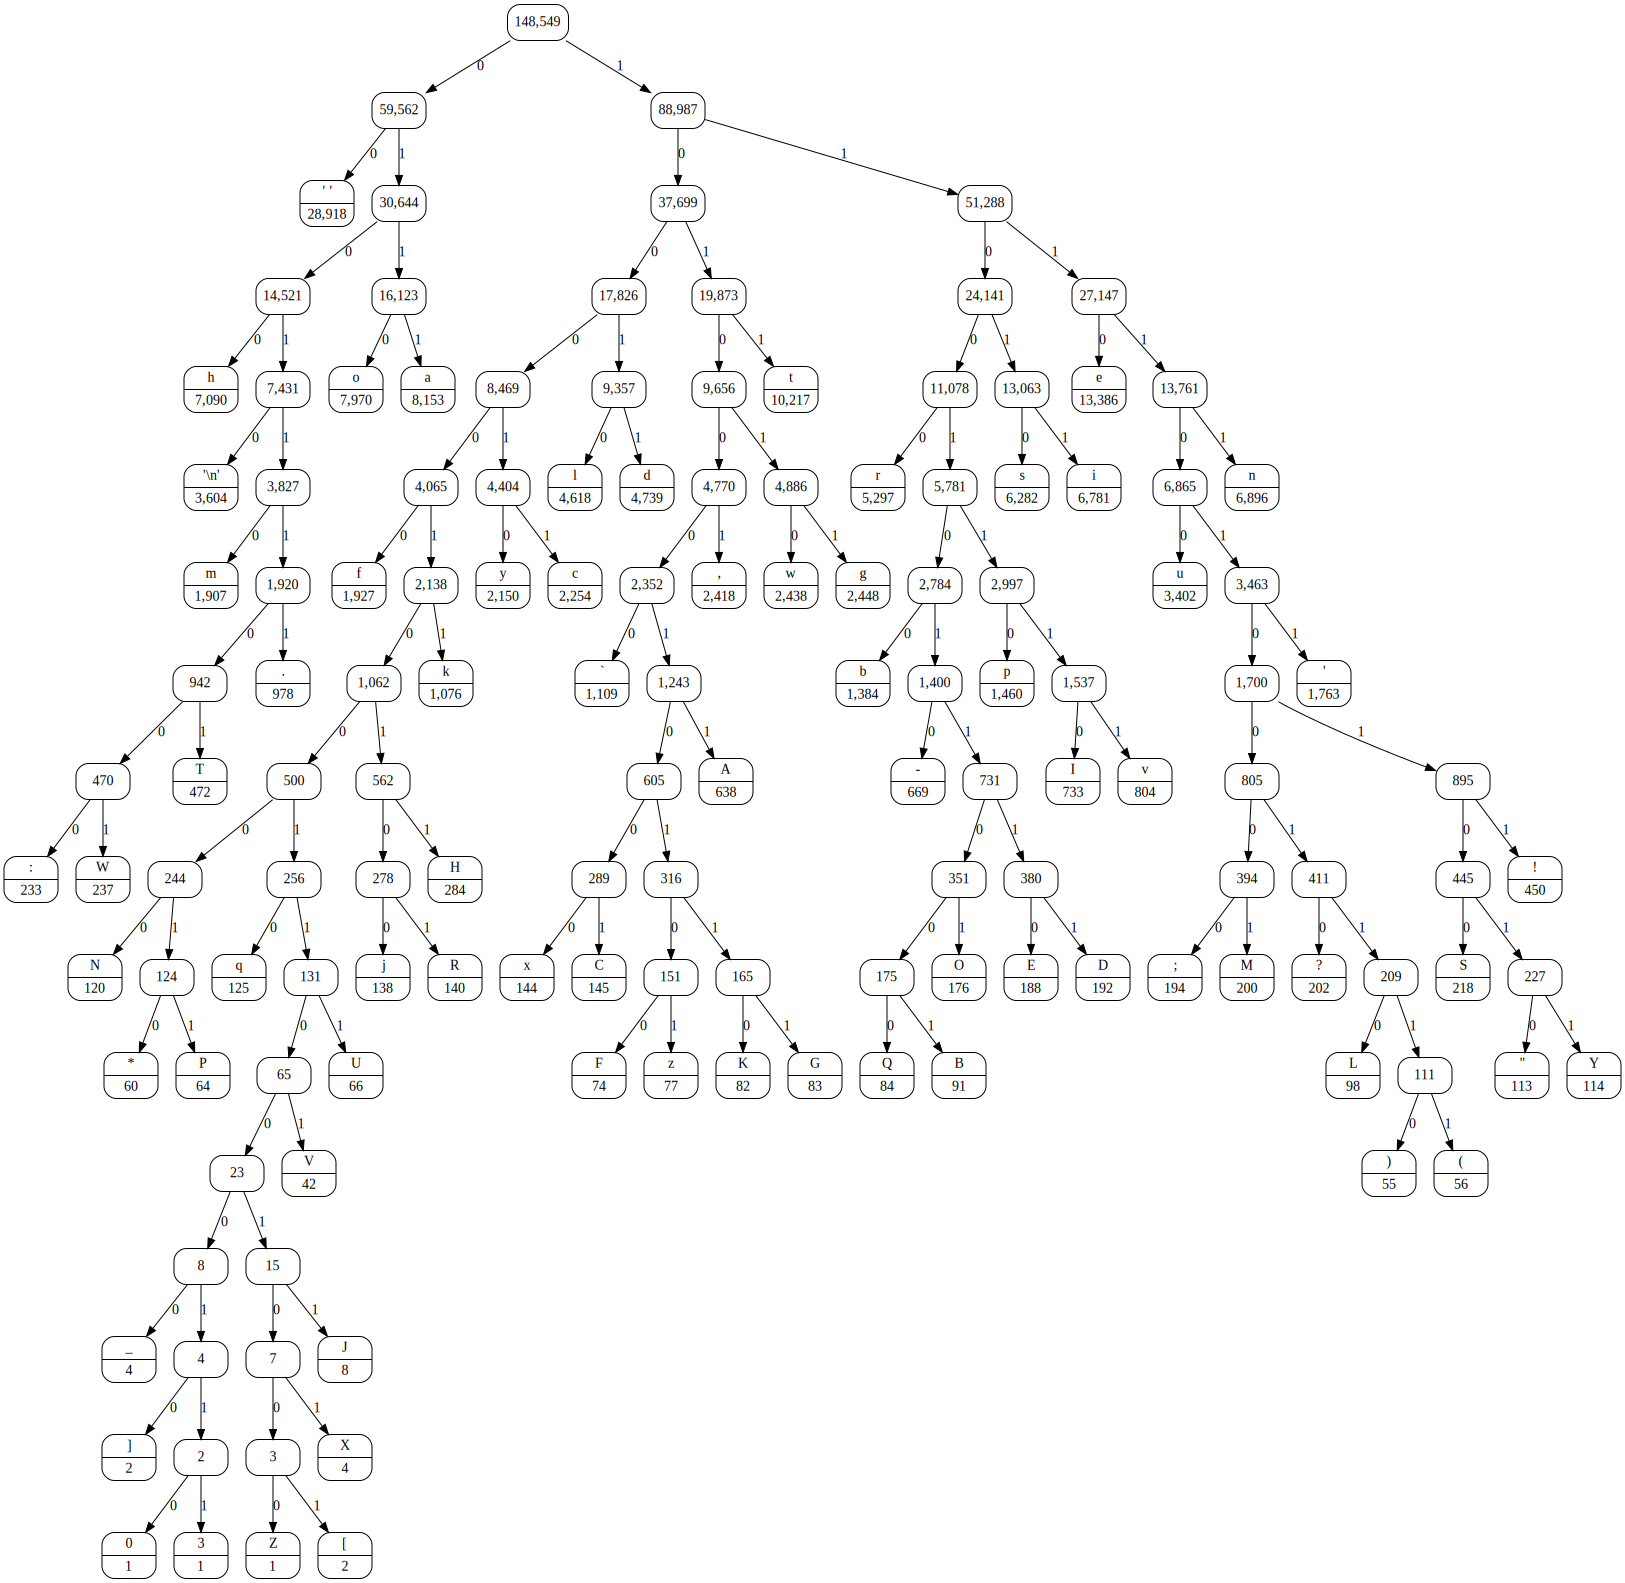

cost of encoding with Huffman coding tree : 676,663 bits
cost of encoding with 7 bits              : 1,039,843 bits
savings: 34.92642639321513%


0.3492642639321513

In [25]:
demo_file('alice.txt')

In [26]:
!cat moby-dick.txt

Moby Dick 

Herman Melville

CHAPTER 1. Loomings.


Call me Ishmael. Some years ago--never mind how long precisely--having
little or no money in my purse, and nothing particular to interest me on
shore, I thought I would sail about a little and see the watery part of
the world. It is a way I have of driving off the spleen and regulating
the circulation. Whenever I find myself growing grim about the mouth;
whenever it is a damp, drizzly November in my soul; whenever I find
myself involuntarily pausing before coffin warehouses, and bringing up
the rear of every funeral I meet; and especially whenever my hypos get
such an upper hand of me, that it requires a strong moral principle to
prevent me from deliberately stepping into the street, and methodically
knocking people's hats off--then, I account it high time to get to sea
as soon as I can. This is my substitute for pistol and ball. With a
philosophical flourish Cato throws himself upon his sword; I quietly
take to the ship. There is not

our fur clothing. For some days we had very little wind; it was not
till the nineteenth that a brisk gale from the northwest sprang up. An
uncommon large whale, the body of which was larger than the ship itself,
lay almost at the surface of the water, but was not perceived by any
one on board till the moment when the ship, which was in full sail,
was almost upon him, so that it was impossible to prevent its striking
against him. We were thus placed in the most imminent danger, as this
gigantic creature, setting up its back, raised the ship three feet at
least out of the water. The masts reeled, and the sails fell altogether,
while we who were below all sprang instantly upon the deck, concluding
that we had struck upon some rock; instead of this we saw the monster
sailing off with the utmost gravity and solemnity. Captain D'Wolf
applied immediately to the pumps to examine whether or not the vessel
had received any damage from the shock, but we found that very happily
it had escaped enti


hatchway. Removing this hatch we expose the great try-pots, two in
number, and each of several barrels' capacity. When not in use, they are
kept remarkably clean. Sometimes they are polished with soapstone
and sand, till they shine within like silver punch-bowls. During the
night-watches some cynical old sailors will crawl into them and coil
themselves away there for a nap. While employed in polishing them--one
man in each pot, side by side--many confidential communications
are carried on, over the iron lips. It is a place also for profound
mathematical meditation. It was in the left hand try-pot of the Pequod,
with the soapstone diligently circling round me, that I was first
indirectly struck by the remarkable fact, that in geometry all bodies
gliding along the cycloid, my soapstone for example, will descend from
any point in precisely the same time.

Removing the fire-board from the front of the try-works, the bare
masonry of that side is exposed, penetrated by the two iron mouths o

{('d', 36996), ('O', 772), ('X', 15), ('9', 31), ('S', 1967), ('z', 589), ('c', 21101), ('r', 50519), ('T', 2202), ('u', 26138), ('C', 1041), ('!', 1741), ('Z', 34), (')', 200), ('6', 31), ('M', 676), ('B', 1363), ('J', 243), ('E', 905), (';', 4143), ('v', 8285), ('F', 732), ('N', 981), ('i', 61040), ('s', 61138), ('R', 639), ('K', 139), (':', 192), ('t', 84349), ('.', 7385), ('$', 2), ('n', 63573), ('h', 60487), ('q', 1224), ('a', 74117), ('y', 16322), ('A', 2377), ('7', 47), ('j', 818), ('3', 45), (']', 2), ('k', 7799), ('&', 2), ('0', 123), ('W', 1210), ('l', 41316), ('V', 134), ('w', 20564), (' ', 190501), ('f', 19743), ('I', 3342), ('b', 15238), ('-', 5739), ('?', 999), ('x', 991), ('8', 47), ('G', 575), ('U', 178), ('\n', 21213), ('"', 2878), (',', 18947), ('5', 52), ('4', 34), ('(', 200), ('[', 2), ('e', 114118), ('Q', 320), ('*', 45), ('P', 991), ('g', 19918), ('L', 735), ('p', 15970), ('o', 67363), ('m', 22229), ('H', 1292), ("'", 2848), ('D', 661), ('Y', 281), ('2', 54), ('1'

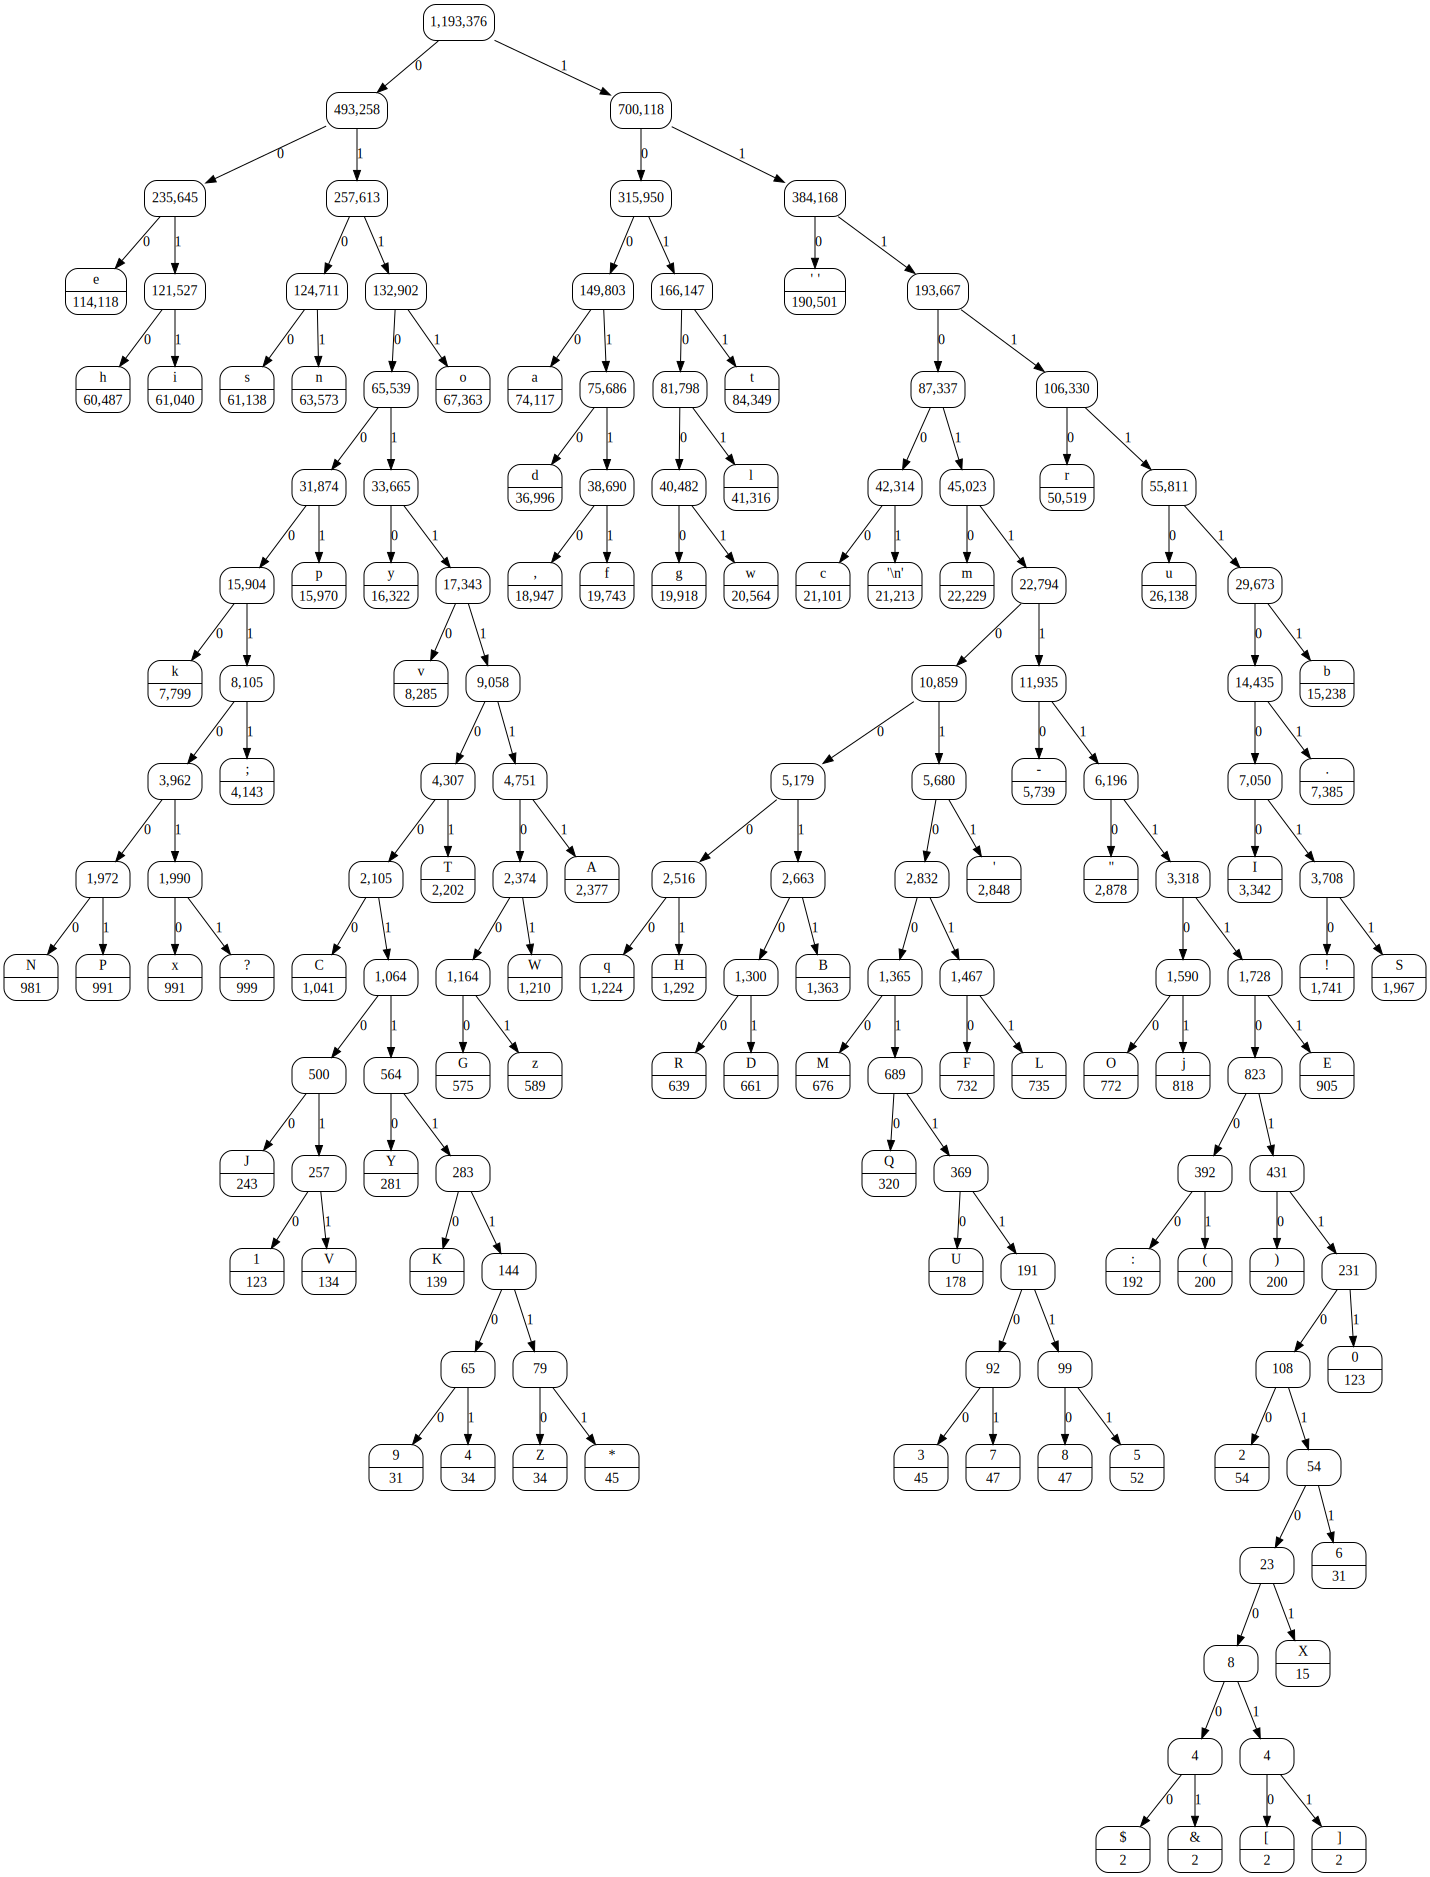

cost of encoding with Huffman coding tree : 5,389,231 bits
cost of encoding with 7 bits              : 8,353,632 bits
savings: 35.48637287349982%


0.35486372873499816

In [27]:
demo_file('moby-dick.txt')